In [2]:
!pip3 install numpy pandas matplotlib sklearn backtesting
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
import sys
sys.path.append(r"c:\users\chris\appdata\local\programs\python\python37\lib\site-packages")

In [3]:
d_df  = pd.read_csv('../bitfear/direction.csv')
d_df['timestamp'] = pd.to_datetime(d_df['timestamp'], format='%Y-%m-%d %H:%M:%S').astype(int)
d_df['vxbt_direction_next'] = d_df['vxbt_direction'].shift(1)
d_df = d_df.dropna().iloc[::-1].reset_index(drop = True)
d_df

,timestamp,vxbt_direction,tweet_vol_direction,sentiment_direction,gtrend_direction,index_direction,vxbt_direction_next
0,1556668800000000000,0,0,0,0,0,1.0
1,1556669100000000000,1,-1,-1,-1,-1,1.0
2,1556669400000000000,1,-1,1,-1,1,-1.0
3,1556669700000000000,-1,-1,1,-1,1,1.0
4,1556670000000000000,1,-1,0,-1,1,1.0
...,...,...,...,...,...,...,...
86366,1582587300000000000,-1,0,1,1,0,1.0
86367,1582587600000000000,1,-1,1,1,-1,-1.0
86368,1582587900000000000,-1,-1,1,1,1,-1.0
86369,1582588200000000000,-1,-1,1,1,1,1.0


In [ ]:
rolling_window = 14 * 24 * 12
two_hour_window = 24

timestamp = []
prediction = []
x_train = []
y_train = []

# Using the parameters that were determined the best in time_series_anaylsis.ipynb
model = GradientBoostingClassifier(learning_rate=0.01, n_estimators=500, max_depth=4, min_samples_split=2,
                                    min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)

counter = 0

for i in range(1, rolling_window+1):
    x_train.append(d_df[['vxbt_direction', 'tweet_vol_direction', 'sentiment_direction', 'gtrend_direction', 'index_direction']]
                   .iloc[i:i + two_hour_window].to_numpy().ravel())
    y_train += [int(d_df['vxbt_direction_next'][i])+1]


for j in range(rolling_window + two_hour_window, bt_df.shape[0]):
    model.fit(np.asarray(x_train), np.asarray(y_train))
    
    test = (d_df[['vxbt_direction', 'tweet_vol_direction', 'sentiment_direction', 'gtrend_direction', 'index_direction']]
                   .iloc[j - two_hour_window:j ].to_numpy().ravel())
    
    probs = model.predict_proba([test]).tolist()[0]
    prediction += [probs]
    timestamp += [d_df['timestamp'][j]]
    
    x_train.pop(0)
    y_train.pop(0)
            
    x_train += [test]
    y_train += [int(d_df['vxbt_direction_next'][j])+1]
    
    
probability_df = {'timestamp':timestamp, 'probabilities':prediction}
probability_df = pd.DataFrame(probability_df)
probability_df
    
    
probability_df.to_csv('../datasets/probability_df.csv')

In [4]:
probability_df  = pd.read_csv('../bitfear/probability_df.csv').drop(['Unnamed: 0'], axis = 1)
probability_df

,timestamp,probabilities
0,1557885900000000000,"[0.045614855600692374, 0.0458413109555619, 0.9..."
1,1557886200000000000,"[0.03628707853993871, 0.048813410336569524, 0...."
2,1557886500000000000,"[0.8671896525729221, 0.07898504313969687, 0.05..."
3,1557886800000000000,"[0.2022053786760509, 0.5198502834585526, 0.277..."
4,1557887100000000000,"[0.8537587358346377, 0.09580749120702955, 0.05..."
...,...,...
82310,1582587300000000000,"[0.24826335288905435, 0.34174169595380266, 0.4..."
82311,1582587600000000000,"[0.2852220439272728, 0.254424443414297, 0.4603..."
82312,1582587900000000000,"[0.2972697694432418, 0.18758387642218333, 0.51..."
82313,1582588200000000000,"[0.306440910688895, 0.2877630270663964, 0.4057..."


In [5]:
btc_index_dbit_df = pd.read_csv('../bitfear/deribit_btc_usd_index_19-05-01_20-05-31_5min.csv')
btc_index_dbit_df['Date and Time'] = pd.to_datetime(btc_index_dbit_df['Date and Time'], format='%Y-%m-%d %H:%M:%S').astype(int)
btc_index_dbit_df = btc_index_dbit_df.rename(columns={"Date and Time": "timestamp"})
btc_index_dbit_df

,timestamp,Price
0,1556668800000000000,5269.46
1,1556669100000000000,5268.33
2,1556669400000000000,5272.10
3,1556669700000000000,5277.00
4,1556670000000000000,5289.70
...,...,...
114331,1590968100000000000,9433.96
114332,1590968400000000000,9410.57
114333,1590968700000000000,9418.37
114334,1590969000000000000,9443.99


In [6]:
bt_df = probability_df.merge(btc_index_dbit_df, left_on='timestamp', right_on = 'timestamp')
bt_df['timestamp'] = pd.to_datetime(bt_df['timestamp'], format='%Y-%m-%d %H:%M:%S')
bt_df = bt_df.rename(columns={" Price": "High"}).drop(['probabilities'], axis = 1)
bt_df['Low'] = bt_df['Open'] = bt_df['Close'] = bt_df['High']
bt_df = bt_df.set_index('timestamp')
bt_df

,High,Low,Open,Close
timestamp,,,,
2019-05-15 02:05:00,7977.13,7977.13,7977.13,7977.13
2019-05-15 02:10:00,8018.31,8018.31,8018.31,8018.31
2019-05-15 02:15:00,8037.82,8037.82,8037.82,8037.82
2019-05-15 02:20:00,8029.34,8029.34,8029.34,8029.34
2019-05-15 02:25:00,8027.24,8027.24,8027.24,8027.24
...,...,...,...,...
2020-02-24 23:35:00,9639.89,9639.89,9639.89,9639.89
2020-02-24 23:40:00,9634.59,9634.59,9634.59,9634.59
2020-02-24 23:45:00,9648.86,9648.86,9648.86,9648.86


In [11]:
from backtesting import Backtest, Strategy

from sklearn.ensemble import GradientBoostingClassifier

x = []
y = []

for j in range(70):
    
    class BitFear(Strategy):
        def init(self):
            Close = self.data.Close
            self.probs = probability_df
            self.t = 0.3 + 0.01 * j


        def next(self):
            i = len(self.data.Open)-1
            class_probabilities = self.probs['probabilities'][i]

            # When read from the csv, class probabilities become a string
            class_probabilities = class_probabilities.strip('][').split(', ')
            predicted_class = class_probabilities.index(max(class_probabilities))

            if predicted_class == 2 and float(class_probabilities[predicted_class]) > self.t:
                self.buy()
            elif predicted_class == 0 and float(class_probabilities[predicted_class]) > self.t:
                self.sell()

    bt = Backtest(bt_df, BitFear, cash=10000, commission = 0)
    
    x += [round(0.3 + 0.01 * j,2)]
    y += [bt.run()['Sharpe Ratio']]

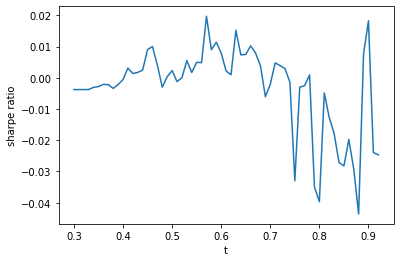

In [12]:
plt.plot(x, y) 
  
plt.xlabel('t') 

plt.ylabel('sharpe ratio') 

plt.show() 